In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1


#### Now, create a train/test split (80/20) with PAY_1 and LIMIT_BAL as features and default payment next month as values. Use a random state of 24.

In [3]:
# Create a train/test split
features  = ['PAY_1','LIMIT_BAL']
target = ['default payment next month']
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,test_size=0.20,random_state=24)
print("train data", train.shape)
print("test data",test.shape)

train data (21331, 30)
test data (5333, 30)


In [4]:
X_train = train[features].dropna()
y_train = train[target].dropna()
X_test = test[features].dropna()
y_test = test[target].dropna()

In [5]:
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (21331, 2)
y_train (21331, 1)
X_test (5333, 2)
y_test (5333, 1)


#### Next, import LogisticRegression, with the default options, but set the solver to 'liblinear'

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')
# Fit the logistic regression model on training data
lr.fit(X_train,y_train)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
# Make predictions using `.predict()`
predict = lr.predict(X_test)
predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
# Find class probabilities using `.predict_proba()`
pred_proba = lr.predict_proba(X_test)
pred_proba[:,1]

array([0.25173076, 0.415703  , 0.20395547, ..., 0.415703  , 0.17278502,
       0.33606565])

In [9]:
lr.score(X_test,y_test)

0.7834239639977498

#### Then, pull out the coefficients and intercept from the trained model and manually calculate predicted probabilities. You'll need to add a column of 1s to your features, to multiply by the intercept.

#### Next, using a threshold of 0.5, manually calculate predicted classes. Compare this to the class predictions output by scikit-learn.

In [10]:
# Get coefficients and intercepts from trained model
coef = lr.coef_
intercept = lr.intercept_
print("Coefficient is",lr.coef_)
print("Intercept is",lr.intercept_)

Coefficient is [[ 8.27451187e-11 -6.80876727e-06]]
Intercept is [-6.57647457e-11]


In [11]:
#calculate probability
t1= coef[0][0]
t2 = coef[0][1]
a =  X_test['PAY_1']
b =  X_test['LIMIT_BAL']
x = t1*a + t2*b + intercept
manual_pred = 1/(1 + np.exp(-x)) 
if (all(pred_proba[:,1]) ==all(manual_pred)):
    print("predicted Probability are Same")
else:
    print("diff")

predicted Probability are Same


In [12]:
# Manually calculate predicted classes
manual_pred
mask = list(manual_pred>0.5)
manual_prediction=[]

for i in mask:
    if (i==False):
        manual_prediction.append(0)
    else:
        manual_prediction.append(1)
manual_prediction = np.array(manual_prediction)
manual_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
# Compare to scikit-learn's predicted classes
print("manual prediction class",manual_prediction)
print("sklearn prediction class",predict)

manual prediction class [0 0 0 ... 0 0 0]
sklearn prediction class [0 0 0 ... 0 0 0]


In [14]:
if (all(manual_prediction) == all(predict)):
    print("both class prediction are same")
else:
    print("different")

both class prediction are same


##### Finally, calculate ROC AUC using both scikit-learn's predicted probabilities, and your manually predicted probabilities, and compare.

In [15]:
# Use scikit-learn's predicted probabilities to calculate ROC AUC
pos_proba = pred_proba[:,1]
pos_proba

array([0.25173076, 0.415703  , 0.20395547, ..., 0.415703  , 0.17278502,
       0.33606565])

In [16]:
from sklearn.metrics import roc_auc_score
scorer_sklearn = roc_auc_score(y_test, pos_proba)
scorer_sklearn

0.627207450280691

Text(0.5, 1.0, 'ROC curve')

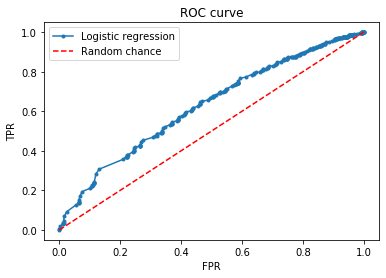

In [17]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fpr, tpr, '.-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

In [18]:
pos_proba_manual = manual_pred[:]
pos_proba_manual

14306    0.251731
2978     0.415703
16641    0.203955
18580    0.203955
131      0.415703
           ...   
18160    0.278236
19779    0.415703
6666     0.415703
18990    0.172785
23253    0.336066
Length: 5333, dtype: float64

In [19]:
from sklearn import metrics
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pos_proba_manual)

Text(0.5, 1.0, 'ROC curve')

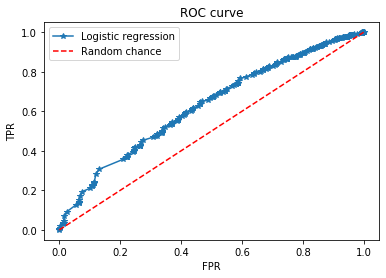

In [20]:
plt.plot(fpr1, tpr1, '*-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

In [21]:
from sklearn.metrics import roc_auc_score
scorer_manual = roc_auc_score(y_test, pos_proba_manual)
scorer_manual

0.627207450280691